## Dropout : A simple way to Prevent Neural Networks from Overfitting


In this notebook, we experiment with dropouts on MNIST data set. The aim is recreate the experiment results given in section 6.1.1 in the paper https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

This section compares the neural networks with and without dropouts for MNIST dataset.

MNIST dataset is available with Keras. It consists of 28 x 28 pixel handwritten digit images.


In [1]:
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape {}".format(x_train.shape))
print("y_train shape {}".format(y_train.shape))
print("x_test shape {}".format(x_test.shape))
print("x_train shape {}".format(y_test.shape))



Using TensorFlow backend.


x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
x_train shape (10000,)


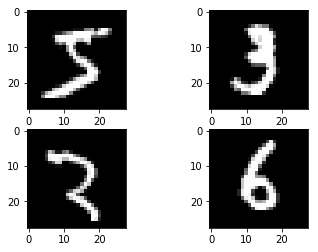

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
plt.imshow(x_train[0], cmap = plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[10], cmap = plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[500], cmap = plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[1020], cmap = plt.get_cmap('gray'))
plt.show()

In [3]:
from keras.utils import np_utils

## One hot encoder
train_one_hot =  np_utils.to_categorical(y_train)
test_one_hot  = np_utils.to_categorical(y_test)

print("train one hot shapec {}".format(train_one_hot.shape))

train one hot shapec (60000, 10)


In [4]:
input_dim = x_train.shape[1:]
input_dim

(28, 28)

## Model 1 
----
28 x 28 --- Flatten --> 784 --Dense--> 1024, Relu --Dense--> 1024, Relu --softmax--> 10 


batch_size = 256
epochs = 25
learning_rate = 0.01
momentum = 0.0
decay = 0.0



In [ ]:
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.callbacks import History, EarlyStopping
from keras.models import Model 
from keras import optimizers

import numpy as np
np.random.seed(123)


batch_size = 256
epochs = 100
learning_rate = 0.01
momentum = 0.0
decay = 0.0
early_stop_th = 10**-5


# Stop the training if the accuracy is not moving more than a delta
# keras.callbacks.History is by default added to all keras model
callbacks = [EarlyStopping(monitor='acc', min_delta=early_stop_th, patience=5, verbose=0, mode='auto')]

# Code up the network
x_input = Input(input_dim)
x = Flatten()(x_input)
x = Dense(1024, activation='relu', name ="dense1")(x)
x = Dense(1024, activation='relu', name = "dense2")(x)
predictions = Dense(10, activation='softmax')(x)

# Optimizer
sgd = optimizers.SGD(lr=0.01, momentum=0, decay=0, nesterov=False)


# Create and train model
model = Model(inputs = x_input, outputs = predictions)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, train_one_hot, validation_split = 0.1, batch_size = batch_size,callbacks = callbacks ,epochs = epochs, verbose = 1)


In [ ]:
hist.history.keys()

In [ ]:
def plot_training(hist):

    fig = plt.figure(figsize=(8,6))
    plt.tight_layout()
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Train Loss and Validation Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc='upper left')
    plt.subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title("Train Accuracy and Validation Accurcy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc='upper left')



plot_training(hist)


## Plot the model

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))




In [ ]:
## Evaluate the model on train and test

def print_metrics(model,x_train, train_one_hot, x_test, test_one_hot):
    metrics = model.evaluate(x=x_train, y=train_one_hot, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)
    print("Train Evaluation\n")
    for k,v in zip(model.metrics_names,metrics):
        print (k,v)
    print('error {}'.format(1-v))

    print("\nTest Evaluation\n")
    metrics = model.evaluate(x=x_test, y=test_one_hot, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)
    for k,v in zip(model.metrics_names,metrics):
        print (k,v)
    print('error {}'.format(1-v))


print_metrics(model,x_train, train_one_hot, x_test, test_one_hot)


## Refer to ../scripts/folder for experiments

Final hyper paramters from the experiments

Best performing model chosen hyper-parameters:
{'Dropout_1': 0.026079803111884514, 'Dropout': 0.4844455237320119}


Best performing model chosen hyper-parameters:
{'lr': 0.8713270582626444}


{'momentum': 0.8671876498073315}


Best performing model chosen hyper-parameters:
{'max_norm': 2.886226647301249, 'max_norm_1': 1.0069271927587264}







In [5]:
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.callbacks import History, EarlyStopping
from keras.models import Model 
from keras import optimizers
from keras.datasets import mnist
from keras.utils import np_utils
from hyperas.distributions import uniform
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe
from keras.constraints import max_norm


import numpy as np
np.random.seed(123)


def mnist_data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    nb_classes = 10
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = mnist_data()

batch_size = 256
epochs = 50
learning_rate = 0.8713270582626444
momentum = 0.8671876498073315
decay = 0.0
early_stop_th = 10**-10
input_dim = (784,)

dropout_1 = 0.026079803111884514
dropout_2 = 0.4844455237320119

mx_n1 = 2.88622664730124
mx_n2 = 1.0069271927587264

x_input = Input(input_dim)
x = Dropout(dropout_1)(x_input)
x = Dense(1024, activation='relu', name ="dense1",kernel_constraint=max_norm( mx_n1 ) )(x)
x = Dropout(dropout_2)(x)
x = Dense(1024, activation='relu', name = "dense2",kernel_constraint=max_norm( mx_n2 ) )(x)
predictions = Dense(10, activation='softmax')(x)

# Optimizer
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=0, nesterov=False)

callbacks = [EarlyStopping(monitor='acc', min_delta=early_stop_th, patience=5, verbose=0, mode='auto')]


# Create and train model
model = Model(inputs = x_input, outputs = predictions)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=x_train,y= y_train, validation_split = 0.1, callbacks = callbacks, batch_size = batch_size ,epochs = epochs, verbose = 1)
metrics = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0, sample_weight=None, steps=None)


accuracy = metrics[1]

print("Accuracy {}  Error {}".format(accuracy, 1-accuracy))


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 177us/step - loss: 0.6935 - acc: 0.8012 - val_loss: 0.2437 - val_acc: 0.9300
Epoch 2/50
54000/54000 [==============================] - 9s 169us/step - loss: 0.5075 - acc: 0.8505 - val_loss: 0.2676 - val_acc: 0.9308
Epoch 3/50
54000/54000 [==============================] - 9s 172us/step - loss: 0.4996 - acc: 0.8563 - val_loss: 0.3459 - val_acc: 0.8872
Epoch 4/50
54000/54000 [==============================] - 9s 170us/step - loss: 0.5081 - acc: 0.8537 - val_loss: 0.3486 - val_acc: 0.8992
Epoch 5/50
54000/54000 [==============================] - 10s 193us/step - loss: 0.6460 - acc: 0.8081 - val_loss: 0.4260 - val_acc: 0.8907
Epoch 6/50
54000/54000 [==============================] - 9s 176us/step - loss: 0.6477 - acc: 0.8062 - val_loss: 0.4814 - val_acc: 0.8610
Epoch 7/50
54000/54000 [==============================] - 9s 175us/step - loss: 0.6965 - acc: 0.7941 - val_loss: 0.5539 -